In [1]:
import xml.etree.ElementTree as ET
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
# define the structure of a node of the tree
class Node:
    def __init__(self, label, refinement="disjunctive", comment=""):
        self.label = label
        self.refinement = refinement
        self.type, self.action, self.cost, self.role = self.comment_to_data(comment)
        
    def comment_to_data(self, comment):
        type, action, cost, role = "", "", "", ""
        
        for line in comment.split('\n'):
            if line.startswith('Type:'):
                type = line.split(': ')[1]
            elif line.startswith('Action:'):
                action = line.split(': ')[1]
            elif line.startswith('Cost:'):
                cost = line.split(': ')[1]
            elif line.startswith('Role:'):
                role = line.split(': ')[1]
                
        return type, action, cost, role
    
    def to_string(self):
        return "Label: " + self.label + "\nRefinement: " + self.refinement + "\nType: " + self.type + "\nAction: " + self.action + "\nCost: " + self.cost + "\nRole: " + self.role
            

In [3]:
# define the structure of the tree
class Tree:
    def __init__(self):
        self.root = None
        self.nodes = []
        self.edges = []
        
    def add_node(self, node):
        if self.nodes == []:
            self.root = node
        self.nodes.append(node)
        
    def add_edge(self, parent, child):
        self.edges.append((parent, child))
        
    def get_parent(self, node):
        for edge in self.edges:
            if edge[1] == node:
                return edge[0]
        return None
    
    def get_children(self, label):
        children = set()
        for edge in self.edges:
            if edge[0] == label:
                children.add(edge[1])
        return children
    
    def to_string(self):
        string = ""
        for node in self.nodes:
            string += node.to_string() + "\n\n"
        return string
    
    def to_graph(self):
        G = nx.DiGraph()
        for node in self.nodes:
            G.add_node(node.label, color="Red" if node.role == "Attacker" else "Green")
        for edge in self.edges:
            G.add_edge(edge[0], edge[1])
        return G
    
    def to_dataframe(self):
        data = []
        for node in self.nodes:
            children = self.get_children(node.label)
            parent = self.get_parent(node.label)
            data.append([node.label, node.refinement, node.type, node.action, node.cost, node.role, parent, children])
        return pd.DataFrame(data, columns=["Label", "Refinement", "Type", "Action", "Cost", "Role", "Parent", "Children"])
    

In [4]:
# Function to get the children of a node
def parse_children(node):
    children = []
    for child in node:
        if child.tag == 'node':
            children.append(child)
    return children

# Function to parse a node
def parse_node(node):
    refinement = node.attrib['refinement']
    label = node.find('label').text.replace(" ", "")
    comment = node.find('comment').text

    return Node(label, refinement, comment)

# Function to add the children of a node to the queue
def enqueue_children(queue, children):
    return children + queue

In [5]:
xml = ET.parse('tree/Data_Exfiltration.xml')
r = xml.find('node')

root = parse_node(r)

print(root.to_string())

Label: DataExfiltration
Refinement: disjunctive
Type: Goal
Action: 
Cost: 
Role: Attacker


In [6]:
tree = Tree()
queue = [r]

while queue:
    parent = queue.pop()
    parent_node = parse_node(parent)
    tree.add_node(parent_node)
    
    children = parse_children(parent)
    queue = enqueue_children(queue, children)
    
    for child in children:
        child_label = child.find('label').text.replace(" ", "")
        tree.add_edge(parent_node.label, child_label)


In [7]:
def hierarchy_pos(G, root, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5, pos = None, parent = None):    
        if pos is None:
            pos = {root:(xcenter,vert_loc)}
        else:
            pos[root] = (xcenter, vert_loc)
        children = list(G.neighbors(root))
        if not isinstance(G, nx.DiGraph) and parent is not None:
            children.remove(parent)  
        if len(children)!=0:
            dx = width/len(children) 
            nextx = xcenter - width/2 - dx/2
            for child in children:
                nextx += dx
                pos = hierarchy_pos(G,child, width = dx, vert_gap = vert_gap, 
                                    vert_loc = vert_loc-vert_gap, xcenter=nextx,
                                    pos=pos, parent = root)
        return pos

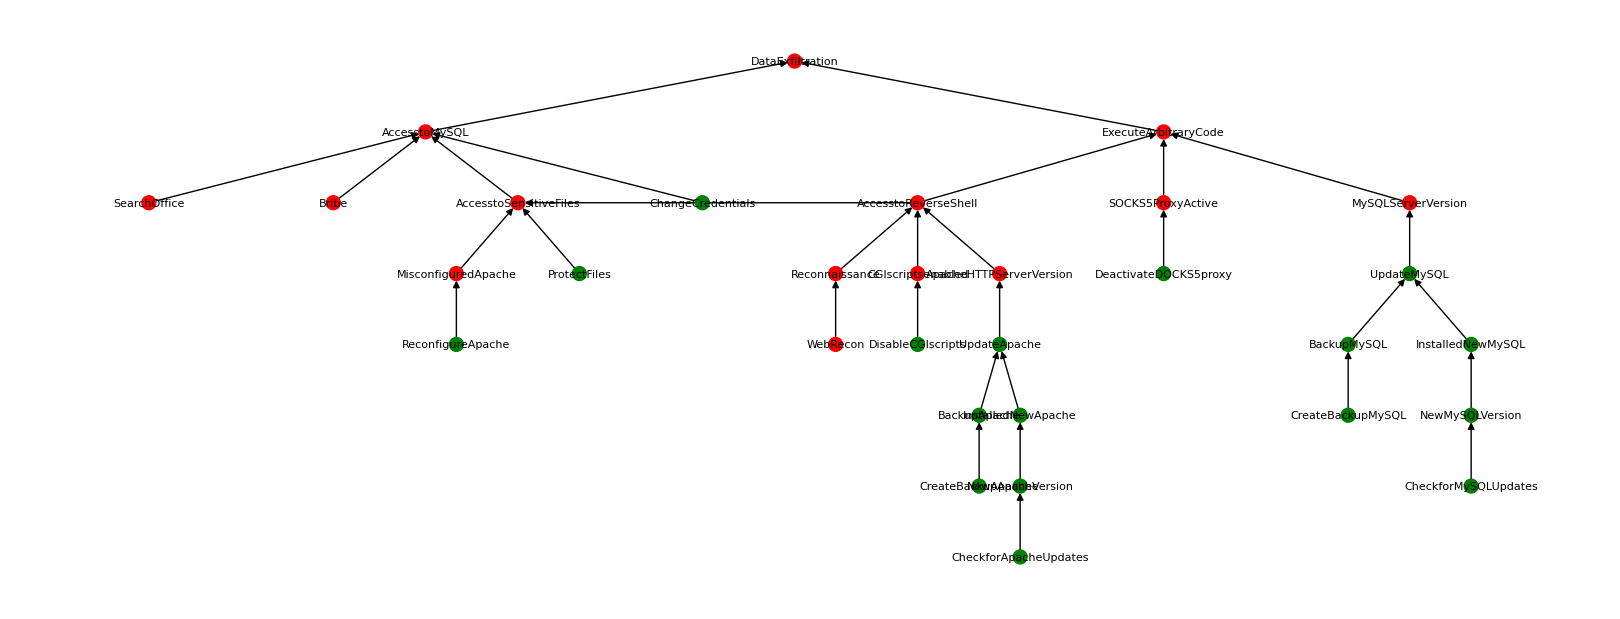

In [8]:
G = tree.to_graph()

fig = plt.figure(figsize=(16, 6))
pos = hierarchy_pos(G, tree.root.label, width=500, xcenter=0.5)   

colors = []
for node in G.nodes:
    colors.append(G.nodes[node]['color'])
    
nx.draw(nx.reverse(G), pos, node_color=colors, with_labels=True, arrows=True, node_size=100, font_size=8)
plt.show()


In [9]:
df = tree.to_dataframe()
df.head()

,Label,Refinement,Type,Action,Cost,Role,Parent,Children
0,DataExfiltration,disjunctive,Goal,,,Attacker,None,"{ExecuteArbitraryCode, AccesstoMySQL}"
1,ExecuteArbitraryCode,conjunctive,Attribute,exfiltrateData,50,Attacker,DataExfiltration,"{MySQLServerVersion, AccesstoReverseShell, SOC..."
2,AccesstoMySQL,disjunctive,Attribute,exfiltrateData,50,Attacker,DataExfiltration,"{SearchOffice, AccesstoSensitiveFiles, Bribe, ..."
3,MySQLServerVersion,conjunctive,Attribute,,,Attacker,ExecuteArbitraryCode,{UpdateMySQL}
4,SOCKS5ProxyActive,conjunctive,Attribute,,,Attacker,ExecuteArbitraryCode,{DeactivateDOCKS5proxy}


In [10]:
goal = df.loc[df["Type"] == "Goal"]["Label"].values[0]

df_attacker = df.loc[df["Role"] == "Attacker"]
df_attacker = df_attacker.loc[df_attacker["Type"] != "Goal"]

df_defender = df.loc[df["Role"] == "Defender"]

list_initial = df_attacker.loc[df_attacker["Action"] == ""]["Label"].to_list()
df_attacker = df_attacker.loc[df_attacker["Action"] != ""]

# list of attributes with the Type "Attribute"
list_attributes = df_attacker.loc[df_attacker["Type"] == "Attribute"]["Label"].values

# df actions with preconditions, effect and costs
attacker_actions = {}
defender_actions = {}

for index, row in df.iterrows():
    attack = row["Action"]
    if attack == "":
        continue
    preconditions = df.loc[row["Parent"] == df["Label"]]["Children"].values[0]

    effect = row["Parent"]
    cost = row["Cost"]
    # get the refinement of the attack from the parent node
    refinement = df.loc[df['Label'] == effect]["Refinement"].values[0]

    if row["Role"] == "Attacker" and attack not in attacker_actions:
        preconditions = [p for p in preconditions if p not in df_defender.loc[df_defender["Type"] == "Attribute"]["Label"].values]
        attacker_actions[attack] = {
            "preconditions" : preconditions, 
            "effect" : effect, 
            "cost" : cost,
            "refinement" : refinement}
    elif row["Role"] == "Defender" and attack not in defender_actions:
            defender_actions[attack] = {
                "preconditions" : preconditions, 
                "effect" : effect, 
                "cost" : cost,
                "refinement" : refinement}

In [11]:
text = "// Turn-based stochastic multi-player games\n"
text += "smg\n\n"

text += "// Players\n"
text += "player attacker\n\tattacker,\n\t"

for a in df_attacker["Action"].values:
    text += "[" + a + "], "
    
text = text[:-2]
text += "\nendplayer\n"

text += "player defender\n\tdefender,\n\t"

for a in df_defender["Action"].values:
    text += "[" + a + "], "
    
text = text[:-2]
text += "\nendplayer\n\n"
        
text += "global sched : [1..2];\n\n// attacker goal\n"

text += f'global {goal} : bool;\nlabel "terminate" = {goal}=true;\n\n// global variables\n'


for a in set(df_attacker.loc[df_attacker["Type"] == "Attribute"]["Label"].values):
    text += "global " + a + " : bool;\n"
    
text += "\n// initial state\n"
for a in set(list_initial):
    text += "global " + a + " : bool init true;\n"

text += "\nmodule attacker\n\n"

for a in set(df_attacker["Action"].values):
    text += f"\t{a} : bool;\n"
    
text += "\n"

for a in attacker_actions.keys():
    preconditions = attacker_actions[a]["preconditions"]
    effect = attacker_actions[a]["effect"]
    if attacker_actions[a]["refinement"] == "disjunctive":
        refinement = "|"
    else:
        refinement = "&"
        
    text += f"\t[{a}] sched=1 & ("
    for p in preconditions:
        text += f"{p} {refinement} "
    text = f"{text[:-3]}) & !{goal} & !{effect} & !{a} -> ({effect}'=true) & ({a}'=true) & (sched'=2);\n"
    
text += "\nendmodule\n\n"

text += "\nmodule defender\n\n"

for a in set(df_defender.loc[df_defender["Type"] == "Attribute"]["Label"].values):
    text += f"\t{a} bool;\n"
    
text += "\n"
    
for a in defender_actions.keys():
    preconditions = defender_actions[a]["preconditions"]
    effect = defender_actions[a]["effect"]
    if defender_actions[a]["refinement"] == "disjunctive":
        refinement = "|"
    else:
        refinement = "&"
        
    text += f"\t[{a}] sched=2 & ("
    for p in preconditions:
        text += f"{p} {refinement} "
    text = f"{text[:-3]}) & !{goal} & !{effect} & -> ({effect}'=true) & (sched'=1);\n"
    
text += "\nendmodule\n\n"

text += 'rewards "attacker"\n\n'

for a in attacker_actions.keys():
    text += f"\t[{a}] true : {attacker_actions[a]['cost']};\n"
    
text += "\nendrewards\n\n"

text += 'rewards "defender"\n\n'

for a in defender_actions.keys():
    text += f"\t[{a}] true : {defender_actions[a]['cost']};\n"
    
text += "\nendrewards\n\n"

with open('prism.txt', 'w') as f:
    f.write(text)
    f.close()